In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

## Reading in the CSV files from each Channel

In [87]:
#Here you will need to put the directory to where the CSV files are located
#This creates a dataframe for each channel

def create_string(location):
    path1 = '/home/cenpa/Ne19/DAQ/FinalConfigSettings/DAQ/{0:s}/UNFILTERED/CH0@DT5725_1146_Data_{0:s}.csv'.format(location)
    path2 = '/home/cenpa/Ne19/DAQ/FinalConfigSettings/DAQ/{0:s}/UNFILTERED/CH1@DT5725_1146_Data_{0:s}.csv'.format(location)
    path3 = '/home/cenpa/Ne19/DAQ/FinalConfigSettings/DAQ/{0:s}/UNFILTERED/CH2@DT5725_1146_Data_{0:s}.csv'.format(location)
    
    path = [path1,path2,path3]
    return path



#write the folder location where 'BiTest-03' is
run_name = 'BiTest-03'
#path = create_string(run_name)



#ch0_df = pd.read_csv(path[0],sep=';')
#ch1_df = pd.read_csv(path[1],sep=';')
#ch2_df = pd.read_csv(path[2],sep=';')

## Process of Splitting Data into indivdual cycles

In [76]:
def Split_Data(ch0_dataFrame,ch1_dataFrame,ch2_dataFrame,minimum_counts = 0):
    """This function returns a list of the data split by run for channel0 and/or channel1 based on the triggering from channel2"""
    #initializing an empty list for each channel(coincidencedata ch0, energydata ch1 ) I want to split into runs triggered
    #by the clock from ch2
    if 
    
    ch0split_data = []
    ch1split_data = []
    
    
    #iterating through the number of times ch2 recieved a signal from our clock
    for i in np.arange(0,len(ch2_dataFrame)-1):
        
        #creating a mask to separate the full data into their individual runs for ch0
        ch0time_mask = np.where((ch0_dataFrame['TIMETAG'] > ch2_dataFrame['TIMETAG'][i]) & 
                                (ch0_dataFrame['TIMETAG'] < ch2_dataFrame['TIMETAG'][i+1]))
        
        
        #creating a mask to separate the full data into their individual runs for ch2
        ch1time_mask = np.where((ch1_dataFrame['TIMETAG'] > ch2_dataFrame['TIMETAG'][i]) & 
                                (ch1_dataFrame['TIMETAG'] < ch2_dataFrame['TIMETAG'][i+1]))
        
        #This number for minimum counts is to remove any possible signals that may occur when we are not running but still collecting data
        if len(ch0time_mask[0]) >= minimum_counts:
            
            #for each run I am creating a new dataframe and storing in a list
            split_dataFrame0 = ch0_dataFrame.iloc[[ch0time_mask][0][0]].copy()
            #resetting the index
            split_dataFrame0 = split_dataFrame0.reset_index(drop=True)

            split_dataFrame1 = ch1_dataFrame.iloc[[ch1time_mask][0][0]].copy()
            #resetting the index
            split_dataFrame1 = split_dataFrame1.reset_index(drop=True)
            
            ch0split_data.extend([split_dataFrame0])
            ch1split_data.extend([split_dataFrame1])
    #returns two arrays of dataframes, one for channel0 and another channel1        
    return ch0split_data, ch1split_data


In [68]:
#initializing the arrays of run data
list_coincidences,list_energy = Split_Data(ch0_df,ch1_df,ch2_df)

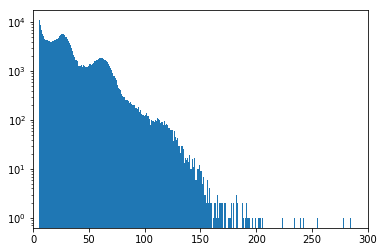

In [73]:
#looking at the 16th single second run recorded during the bismuth test
plt.hist(ch1_df['ENERGY'],bins = np.arange(5,300));
plt.xlim(0,300);
plt.yscale('log')

## Making a function for matching Coincidence data to energy data

In [72]:
#delay is in 10^-12 seconds so 1,000,000 is 1000 ns
def Energylist_Cuts(listofcoincidences,listofenergy,delay=700011):
    #initializing an empty list for the coincidence energies from channel 1
    coincident_energy = []
    
    #iterating through the number of runs our data was split into
    for i in np.arange(len(listofcoincidences)):
        
        #creating a buffer data frame to fill with the ch1 counts found to be coincident with ch0
        bufferpd = pd.DataFrame(columns = listofenergy[0].columns)
        
        #iterating through the times in ch0 that we want to match an energy measurement from ch1 to
        for j in np.arange(len(listofcoincidences[i])):
            
            #creating a mask to look for a single value in the ch1 data that is within a certain delay time away from the ch0 detection time
            coincident_energy_mask = np.where((listofenergy[i]['TIMETAG'] < listofcoincidences[i]['TIMETAG'][j]-delay+7000) & 
                                              (listofenergy[i]['TIMETAG'] > listofcoincidences[i]['TIMETAG'][j]-delay-8000))
            
            #single row of a dataframe to be appended to bufferpd
            info_on_coincident_energy = listofenergy[i].iloc[[coincident_energy_mask][0][0]]
            
            #appending the row of the data frame
            bufferpd = bufferpd.append(info_on_coincident_energy, ignore_index = True)
            
            #giving each column the correct dtype
            bufferpd = bufferpd.astype({"TIMETAG": np.int64, "ENERGY": np.int64, "ENERGYSHORT":np.int64, "FLAGS":object}) 
        
        #adding the data frame of coincident ch1 data for each run
        coincident_energy.extend([bufferpd])
    #returning a list with a length equal to the number of runs the data was split into. Each element is a dataframe for coincidences on ch1 triggered by ch0     
    return coincident_energy

In [73]:
#looking at the energy that is coincident with ch0
tests = Energylist_Cuts(list_coincidences,list_energy,delay = 700011)

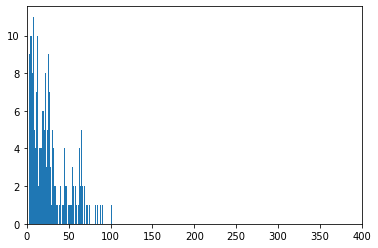

In [240]:
#plotting said energies
plt.hist(tests[0]['ENERGY'],bins=np.arange(0,400));
plt.xlim(0,400);

In [147]:
#This mask format allows us to find the times where energy is within a certain range and relate it directly to our ch0 counts

mask = np.where((tests[0]['ENERGY'] < 200) & (tests[0]['ENERGY'] > 0))

#It doesnt mean much for the bismuth since it has a close to constant counts/time at small scales, but this is a histogram of
#the counts in about every 20th of a second with the above energy constraint


energy_cut_counts = list_coincidences[0]['TIMETAG'].iloc[[mask][0][0]]
energy_cut_coincidence = pd.DataFrame(energy_cut_counts,columns = ['TIMETAG'])


In [16]:
def count_rate(single_run_coincidences, bin_size = 1):
    bin_seconds = bin_size*(10**12)
    singlerun = single_run_coincidences['TIMETAG'] - single_run_coincidences['TIMETAG'].min()
    time_axis = np.arange(0,singlerun.max()-bin_seconds,bin_seconds)
    
    def time_binning(i):
        number_of_counts = np.where((singlerun > i) & 
                                    (singlerun <= i+bin_seconds))
        return len(number_of_counts[0])
    return time_axis*(10**-12), [time_binning(i) for i in time_axis]

In [89]:
def plot_rate(coincidences,cycle_number, bin_size = 1):
    
    x,y = count_rate(coincidences[cycle_number],bin_size = bin_size)
    fig, ax = plt.subplots(1,figsize=(12,5))

    #ax.errorbar(x,y,yerr=np.sqrt(y), label= 'Limits')

    ax.plot(x,y)
    ax.set_title('Run from {0:s} Cycle Number {1:d}'.format(run_name,cycle_number))
    ax.set_ylabel('Counts')
    ax.set_xlabel('Seconds')
    #ax.legend()

   # Running The Code:

   1. Run all the cells listed above.
   
   2. 